In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import pandas_profiling as pp
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta

In [2]:
pac17 = pd.read_csv('PAC_2018_12.csv', sep = ',', error_bad_lines = False, encoding = 'latin-1')
conversao_digs = pd.read_csv('conversao_digs.csv', sep = ',', error_bad_lines = False, encoding = 'utf8')
#pac17 = pac17.drop(columns = ['aaa'])
pac17.shape

(29345, 16)

# Descrição dos dados

# Pré-processamento dos Dados

A coluna *investimento_total* no dataset ```pac17``` contém incosistências de formatação com valores em vírgula e ponto. A célula abaixo troca ```,``` por ```.``` e converte o formato da coluna para numérico.

In [3]:
pac17['investimento_total'] = pac17.investimento_total.replace(',','.', regex=True).astype('float64')

In [4]:
def change_type_by_name(data, string, final_type):
    for col in data.columns:
        if string in col:
            data[col] = data[col].astype(final_type)
    return data
pac17 = change_type_by_name(pac17, 'idn_', 'object')

Considerando apenas os dados quem contém o código __BA__ na sigla do estado do empreendimento e desconsiderando os dados onde `sigla_uf` apresenta valores __NULL__.

In [5]:
pac17 = pac17.dropna(subset = ['sig_uf'])
pacba17 = pac17[pac17['sig_uf'].str.contains('BA')]

In [6]:
print('Obras no estado da Bahia sem valores de investimento: {:.2%}'.format(float(pacba17.investimento_total.isnull().sum())/pacba17.shape[0]))

Obras no estado da Bahia sem valores de investimento: 5.07%


In [7]:
pacba17['id_digs'] = pacba17.id_digs.astype('str')
pacba17['id_digs'] = pacba17['id_digs'].map(lambda x: str(x)[:-2])
conversao_digs['id_digs'] = conversao_digs.id_digs.astype('str')

/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
pacba17 = pacba17.join(conversao_digs.set_index('id_digs'), on='id_digs')

In [9]:
pacba17.dtypes

idn_empreendimento        object 
id_digs                   object 
titulo                    object 
investimento_total        float64
sig_uf                    object 
txt_municipios            object 
txt_executores            object 
dsc_orgao                 object 
idn_estagio               object 
dat_ciclo                 object 
dat_selecao               object 
dat_conclusao_revisada    object 
obra_latitude             object 
obra_longitude            object 
emblematica               object 
observacao                object 
tipo_empreendimento       object 
subeixo                   object 
dtype: object

### Feature Engineering

In [10]:
pacba17['idn_estagio'] = pacba17.idn_estagio.astype('int')

In [11]:
pacba17['estagio'] = np.where(pacba17['idn_estagio'] >= 70, 'em_obras', 'nao_iniciado')
pacba17['estagio'] = np.where(pacba17['idn_estagio'] == 90, 'concluido', pacba17['estagio'])
pacba17.drop(columns=['idn_estagio'])

,idn_empreendimento,id_digs,titulo,investimento_total,sig_uf,txt_municipios,txt_executores,dsc_orgao,dat_ciclo,dat_selecao,dat_conclusao_revisada,obra_latitude,obra_longitude,emblematica,observacao,tipo_empreendimento,subeixo,estagio
19,1567,6002,Sistema Adutor de Jacobina - BA,3.426000e+07,BA,JACOBINA/BA,Estado,Ministério da Integração Nacional,31/12/2018,29/06/2012,02/02/2018,NaN,NaN,NaN,NaN,Recursos Hídricos,Infraestrutura Social e Urbana,concluido
33,2489,1000,BR-101/BA - Duplicação da Divisa SE/BA à Feira de Santana - BA,1.166702e+09,BA,"ALAGOINHAS/BA, AMÉLIA RODRIGUES/BA, ARAÇAS/BA, ENTRE RIOS/BA, ESPLANADA/BA, FEIRA DE SANTANA/BA, RIO REAL/BA, TEODORO SAMPAIO/BA",DNIT,"Ministério dos Transportes, Portos e Aviação Civil",31/12/2018,NaN,NaN,NaN,NaN,NaN,NaN,Rodovias,Infraestrutura Logística,em_obras
55,4508,1000,BR-135/BA - Construção de São Desidério à Divisa BA/MG - BA,9.457615e+08,BA,"ANGICAL/BA, BARREIRAS/BA, COCOS/BA, CORIBE/BA, CORRENTINA/BA, FEIRA DA MATA/BA, FORMOSA DO RIO PRETO/BA, JABORANDI/BA, RIACHÃO DAS NEVES/BA, SANTA RITA DE CÁSSIA/BA, SÃO DESIDÉRIO/BA",DNIT,"Ministério dos Transportes, Portos e Aviação Civil",31/12/2018,NaN,NaN,NaN,NaN,NaN,NaN,Rodovias,Infraestrutura Logística,em_obras
59,4567,2001,"LT 230 kV Eunápolis - Teixeira de Freitas II, C1 - BA",6.751000e+07,BA,"EUNÁPOLIS/BA, TEIXEIRA DE FREITAS/BA",Companhia hidro elétrica do São Francisco,Ministério de Minas e Energia,31/12/2018,NaN,NaN,NaN,NaN,NaN,NaN,Transmissão de Energia Elétrica,Infraestrutura Energética,em_obras
62,4878,2001,SE Pólo 230/69 kV - BA,3.269000e+07,BA,CAMAÇARI/BA,Companhia hidro elétrica do São Francisco,Ministério de Minas e Energia,31/12/2018,NaN,28/02/2016,"12°41'52.800000""S","38°19'25.680000""O",NaN,NaN,Transmissão de Energia Elétrica,Infraestrutura Energética,concluido
76,5723,1000,BR-418/BA - Construção Caravelas - Entr. BR-101/BA - BA,1.186200e+08,BA,"ALCOBAÇA/BA, CARAVELAS/BA",DNIT; Exército,"Ministério dos Transportes, Portos e Aviação Civil",31/12/2018,NaN,30/12/2015,NaN,NaN,NaN,NaN,Rodovias,Infraestrutura Logística,concluido
93,6006,2001,"LT 230 kV Eunápolis - Teixeira de Freitas II, C2 - BA",4.500000e+07,BA,"EUNÁPOLIS/BA, TEIXEIRA DE FREITAS/BA",Companhia hidro elétrica do São Francisco,Ministério de Minas e Energia,31/12/2018,NaN,NaN,NaN,NaN,NaN,NaN,Transmissão de Energia Elétrica,Infraestrutura Energética,em_obras
102,6047,1001,Trecho da Ferrovia de Integração Oeste Leste - Construção Ilhéus/BA - Caetité/BA - BA,4.602700e+09,BA,"BARREIRAS/BA, ILHÉUS/BA",VALEC,"Ministério dos Transportes, Portos e Aviação Civil",31/12/2018,NaN,NaN,NaN,NaN,EMBLEMATICA,NaN,Ferrovia,Infraestrutura Logística,em_obras
111,6118,3003,Metrô de Salvador - Linha 1 - Trecho 2 - Acesso Norte - Pirajá,9.657347e+08,BA,SALVADOR/BA,Companhia de Transporte de Salvador - CTS,Ministério das Cidades,31/12/2018,04/10/2013,15/08/2017,NaN,NaN,NaN,NaN,Mobilidade Urbana,Infraestrutura Social e Urbana,concluido
112,6180,1002,Porto Sem Papel - Fase 2 - Concentrador de Dados e Portal de Informações Portuárias - AL AM AP BA CE ES MA PA PB PE PR RJ RN RS SC SP,1.641500e+08,AL AM AP BA CE ES MA PA PB PE PR RJ RN RS SC SP,"ANGRA DOS REIS/RJ, ANTONINA/PR, ARACRUZ/ES, AREIA BRANCA/RN, ARRAIAL DO CABO/RJ, BARCARENA/PA, BELÉM/PA, CABEDELO/PB, CABO DE SANTO AGOSTINHO/PE, CANDEIAS/BA, FORTALEZA/CE, ILHÉUS/BA, IMBITUBA/SC, ITAGUAÍ/RJ, ITAJAÍ/SC, LAGUNA/SC, MACAPÁ/AP, MACEIÓ/AL, MANAUS/AM, NATAL/RN, NITERÓI/RJ, PARANAGUÁ/PR, PELOTAS/RS, PORTO ALEGRE/RS, RECIFE/PE, RIO GRANDE/RS, SALVADOR/BA, SANTARÉM/PA, SÃO FRANCISCO DO SUL/SC, SÃO GONÇALO DO AMARANTE/CE, SÃO LUÍS/MA, SÃO SEBASTIÃO/SP",Serviço Federal de Processamento de Dados - SERPRO,"Ministério dos Transportes, Portos e Aviação Civil",31/12/2018,NaN,NaN,"22°52'50.757600""S","43°6'15.606000""O",EMBLEMATICA,NaN,Porto,Infraestrutura Logística,em_obras


In [12]:
pacba17.dtypes

idn_empreendimento        object 
id_digs                   object 
titulo                    object 
investimento_total        float64
sig_uf                    object 
txt_municipios            object 
txt_executores            object 
dsc_orgao                 object 
idn_estagio               int64  
dat_ciclo                 object 
dat_selecao               object 
dat_conclusao_revisada    object 
obra_latitude             object 
obra_longitude            object 
emblematica               object 
observacao                object 
tipo_empreendimento       object 
subeixo                   object 
estagio                   object 
dtype: object

### Explorando a coluna `dat_selecao`

1. Preencher os 92 valores vazios no caso de obras concluídas a partir da mediana do número de obras.
2. Preecher os 121 valores vazios no caso de obras em andamento com a moda das datas de seleção (dia, mês, ano).
3. 192 valores vazios no caso de obras ainda não iniciadas.

In [13]:
def values_from_dates(df, column, day, month, year):
    df[day] = df[column].str.slice(0,2)
    df[month] = df[column].str.slice(3,5)
    df[year] = df[column].str.slice(6,10)
    return df
def conclusion_status(df, col):
    df[col] = np.where(df.dat_conclusao_revisada.notna(), 'sim', 'nao')
    return df

- Considera uma parte do dataset em que o estágio das obras é concluído e não há valores nulos na data de seleção.
- Confere que não há valores vazios em `dat_selecao` e `dat_conclusao_revisada`.
- Converte essas colunas para _datetime_.
- Calcula o número de dias das obras e guarda a sua __mediana__.

In [14]:
concluido = pacba17[(pacba17['estagio'] == 'concluido') & (pacba17.dat_selecao.notnull())]

In [15]:
assert concluido.dat_selecao.isnull().sum() == 0 and concluido.dat_conclusao_revisada.isnull().sum() == 0

In [16]:
concluido['dat_selecao'] = pd.to_datetime(concluido['dat_selecao'], dayfirst=True)
concluido['dat_conclusao_revisada'] = pd.to_datetime(concluido['dat_conclusao_revisada'], dayfirst=True)

/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
concluido['dias_obra'] = (concluido['dat_conclusao_revisada'] - concluido['dat_selecao']).dt.days

/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
concluido_median = int(concluido['dias_obra'].median())

In [19]:
del(concluido)

Substitui os valores vazios da `dat_seleção` pela __moda__ onde o `estagio` é diferente de concluído.

In [20]:
nao_concluido_moda = pacba17['dat_selecao'][(pacba17['estagio'] != 'concluido') & (pacba17.dat_selecao.notnull())].mode()

In [21]:
pacba17['dat_selecao'][(pacba17['estagio'] != 'concluido') & (pacba17.dat_selecao.isnull())] = str(nao_concluido_moda[0])

/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
pacba17['dat_conclusao_revisada'] = pacba17['dat_conclusao_revisada'].fillna(pacba17['dat_selecao'])

In [23]:
assert pacba17.dat_conclusao_revisada.isnull().sum() == 0

In [24]:
pacba17['dat_selecao'] = pd.to_datetime(pacba17['dat_selecao'], dayfirst=True)
pacba17['dat_conclusao_revisada'] = pd.to_datetime(pacba17['dat_conclusao_revisada'], dayfirst=True)

In [25]:
pacba17['dat_selecao'] = pacba17['dat_selecao'].fillna(pacba17['dat_conclusao_revisada'] - timedelta(days=concluido_median))

In [26]:
assert pacba17.dat_selecao.isnull().sum() == 0

In [27]:
pacba17['dias_obra'] = (pacba17['dat_conclusao_revisada'] - pacba17['dat_selecao']).dt.days

In [28]:
pacba17['dia_conclusao'] = pacba17.dat_conclusao_revisada.dt.day
pacba17['mes_conclusao'] = pacba17.dat_conclusao_revisada.dt.month
pacba17['ano_conclusao'] = pacba17.dat_conclusao_revisada.dt.year
pacba17['dia_selecao'] = pacba17.dat_selecao.dt.day
pacba17['mes_selecao'] = pacba17.dat_selecao.dt.month
pacba17['ano_selecao'] = pacba17.dat_selecao.dt.year

### Missing values

#### Exclusão das colunas com missing values acima de 50%

Dropa as colunas ``emblematica`` e ``observação`` dado o alto percentual de _missing values_

In [29]:
pacba17 = pacba17.drop(columns = ['emblematica', 'observacao'])

#### Plota as colunas com missing values

In [30]:
def plot_missing(df):
    columns = df.columns
    percent_missing = df.isnull().sum() * 100 / len(df)
    unique = df.nunique()
    dtypes = df.dtypes
    missing_value_data = pd.DataFrame({'column_name': columns,
                                     'percent_missing': percent_missing,
                                     'unique': unique,
                                     'types': dtypes})
    missing_value_data = missing_value_data[missing_value_data['percent_missing']>0]
    missing_value_data=missing_value_data.sort_values(by=['percent_missing'], ascending=False)
    
    plt.figure(figsize=(9, 6))
    ax = sns.barplot(x="column_name", y="percent_missing", hue='types', data=missing_value_data)
    ax.axhline(50, ls='--', color = 'r')
    ax.text(3,51,"50% of missing values", color = 'r')
    ax.set_title("Percentage of Missing Values by column")
    plt.xticks(rotation=45)
    print percent_missing
    plt.show()

/usr/lib/python2.7/dist-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


idn_empreendimento        0.000000
id_digs                   0.000000
titulo                    0.000000
investimento_total        4.786273
sig_uf                    0.000000
txt_municipios            3.281156
txt_executores            0.481638
dsc_orgao                 0.000000
idn_estagio               0.000000
dat_ciclo                 0.000000
dat_selecao               0.000000
dat_conclusao_revisada    0.000000
obra_latitude             5.207706
obra_longitude            5.207706
tipo_empreendimento       0.000000
subeixo                   0.000000
estagio                   0.000000
dias_obra                 0.000000
dia_conclusao             0.000000
mes_conclusao             0.000000
ano_conclusao             0.000000
dia_selecao               0.000000
mes_selecao               0.000000
ano_selecao               0.000000
dtype: float64


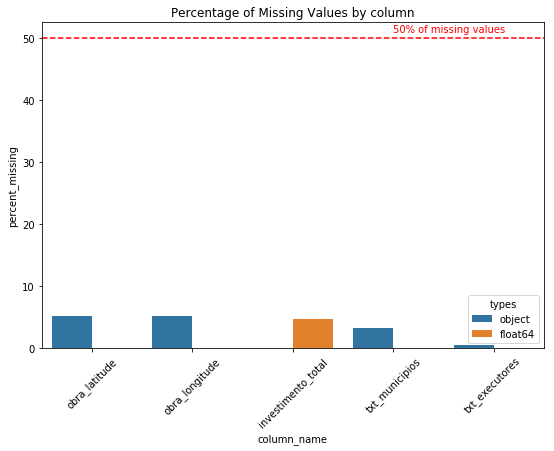

In [31]:
plot_missing(pacba17)

In [32]:
pacba17 = pacba17.dropna(subset=['obra_latitude', 'obra_longitude', 'dsc_orgao','txt_municipios', 'txt_executores'])

### Divisão do dataset para desenvolvimento e produção

Separação do dataset original para o dataset que será usado para treinar e testar o modelo e outro que será usado para o modelor estimar os valores de investimento.
- Critério de split:
    - Dataset de desenvolvimento: `investimento_total` diferentes de nulo;
    - Dataset para produção: `investimento_total` com valores nulo;

In [33]:
shape_dev = pacba17.shape[0]

In [34]:
pacba17 = pacba17.dropna(subset=['investimento_total'])

In [35]:
shape_prod = pacba17.shape[0]

In [36]:
dev = float(shape_prod)/(shape_dev)
prod = float(shape_dev - shape_prod)/(shape_dev)

In [37]:
print('{0:.0%} do dataset será usado para desenvolvimento e {1:.0%} como dados de previsão após finalização do modelo'.format(dev, prod))

98% do dataset será usado para desenvolvimento e 2% como dados de previsão após finalização do modelo


### Tratando outliers

#### `investimento_total`

Detectando Outliers a partir do __Z-score__

In [38]:
z = np.abs(stats.zscore(pacba17['investimento_total']))

In [39]:
print(np.where(z >3))

(array([   1,    2,    3,    9,   10,  333,  334,  372,  373,  388,  389,
        737, 1113, 1114, 1154, 1158, 1159, 1186, 2681, 2682, 2689, 2696,
       2697, 2698, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2910, 2911,
       2912, 2916, 2919]),)


In [40]:
pacba17 = pacba17[z<3]

In [41]:
pacba17['log_investimento_total'] = np.log(pacba17['investimento_total'])

/usr/lib/python2.7/dist-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


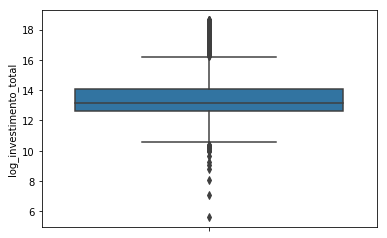

In [42]:
sns.boxplot(y=pacba17['log_investimento_total'])

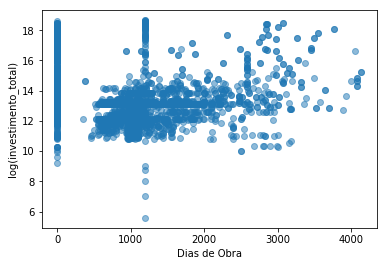

In [43]:
plt.scatter(pacba17['dias_obra'], pacba17['log_investimento_total'], alpha=0.5)
plt.xlabel('Dias de Obra')
plt.ylabel('log(investimento_total)')
plt.show()

/usr/lib/python2.7/dist-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/fguer/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'log(investimento_total)')

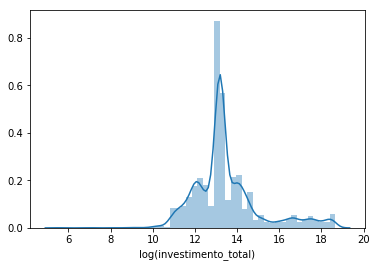

In [44]:
sns.distplot(pacba17['log_investimento_total'])
plt.xlabel('log(investimento_total)')

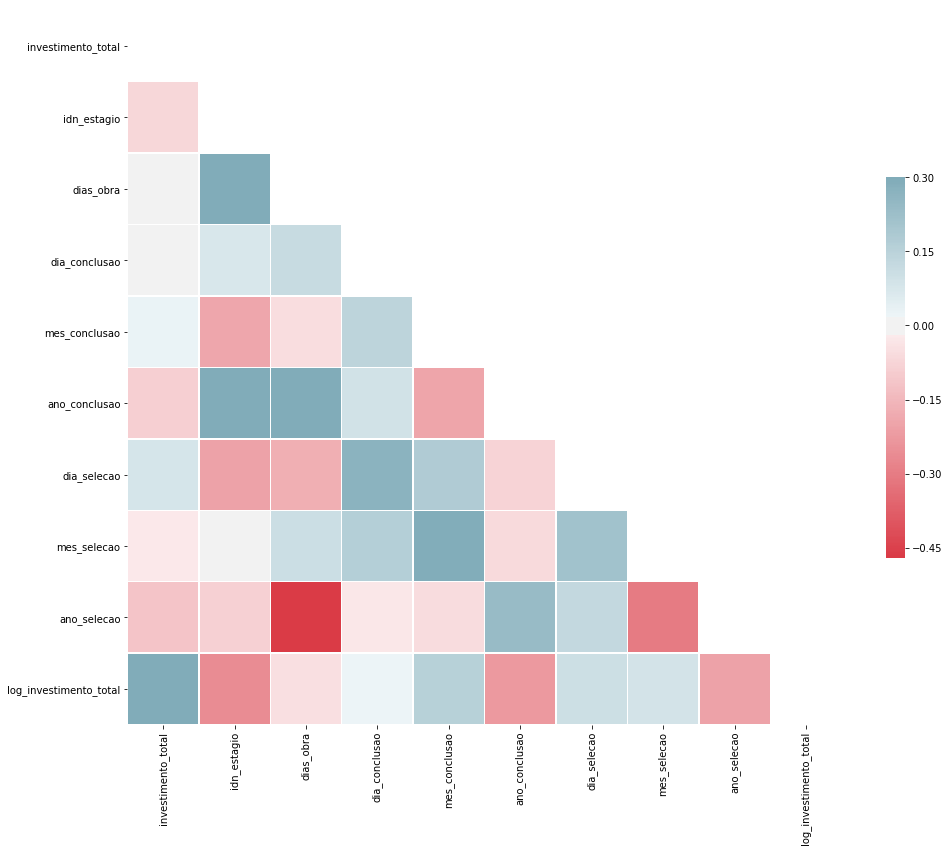

In [45]:
from matplotlib.pyplot import figure
figure(figsize=(16, 14))
corr = pacba17.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

__Count de UFs__
- Criar coluna calculada com o número de estados.
- Dummificar essa coluna (?).

In [46]:
pacba17 = pacba17.drop(columns=['idn_estagio', 'dat_ciclo', 'dat_selecao', 'dat_conclusao_revisada'])

__Converte as colunas Latitude e Longitude de DMS para decimal__

Precisa ser completado: Splitar os campos com valores multiplos e aplicar a função de conversão

Dropa Colunas que serão utilizadas (ou não) porsteriormente:
- `sig_uf`: criar coluna calculada com número de estados.
- `txt_municipios`: criar coluna calculada com número de municípios.
- `obra_latitude`, `obra_longitude`: converter pra decimal.

In [47]:
pacba17.head(2)

,idn_empreendimento,id_digs,titulo,investimento_total,sig_uf,txt_municipios,txt_executores,dsc_orgao,obra_latitude,obra_longitude,...,subeixo,estagio,dias_obra,dia_conclusao,mes_conclusao,ano_conclusao,dia_selecao,mes_selecao,ano_selecao,log_investimento_total
62,4878,2001,SE Pólo 230/69 kV - BA,32690000.00,BA,CAMAÇARI/BA,Companhia hidro elétrica do São Francisco,Ministério de Minas e Energia,"12°41'52.800000""S","38°19'25.680000""O",...,Infraestrutura Energética,concluido,1200,28,2,2016,15,11,2012,17.302580
196,8195,6002,Modernização da Infraestrutura do Perímetro de Irrigação Maniçoba - BA - BA,12434264.95,BA,JUAZEIRO/BA,Codevasf,Ministério da Integração Nacional,"9°24'59.888340""S","40°30'13.040712""O",...,Infraestrutura Social e Urbana,em_obras,0,23,9,2013,23,9,2013,16.335967


In [48]:
pacba17 = pacba17.drop(columns = ['idn_empreendimento', 'titulo', 'sig_uf', 'txt_municipios', 'obra_latitude','obra_longitude'])

### Getting dummies

In [49]:
pacba17_dummies = pd.get_dummies(pacba17,columns=['dsc_orgao', 'tipo_empreendimento', 'subeixo', 'estagio', 'id_digs'], dummy_na=False)

#### WARNING!!!!!!
`txt_executores` com 82 valores únicos está sendo encoded!!

In [50]:
pacba17_dummies = pacba17_dummies.drop(columns=['txt_executores', 'investimento_total'])

Através da matriz de correlação, avaliando a relação entre a variável target `investimento_total` e as outras, percebe-se:
- Alta correlação negativa: Obras pertencentes ao subeixo de Infraestrutura Social apresentam menores 

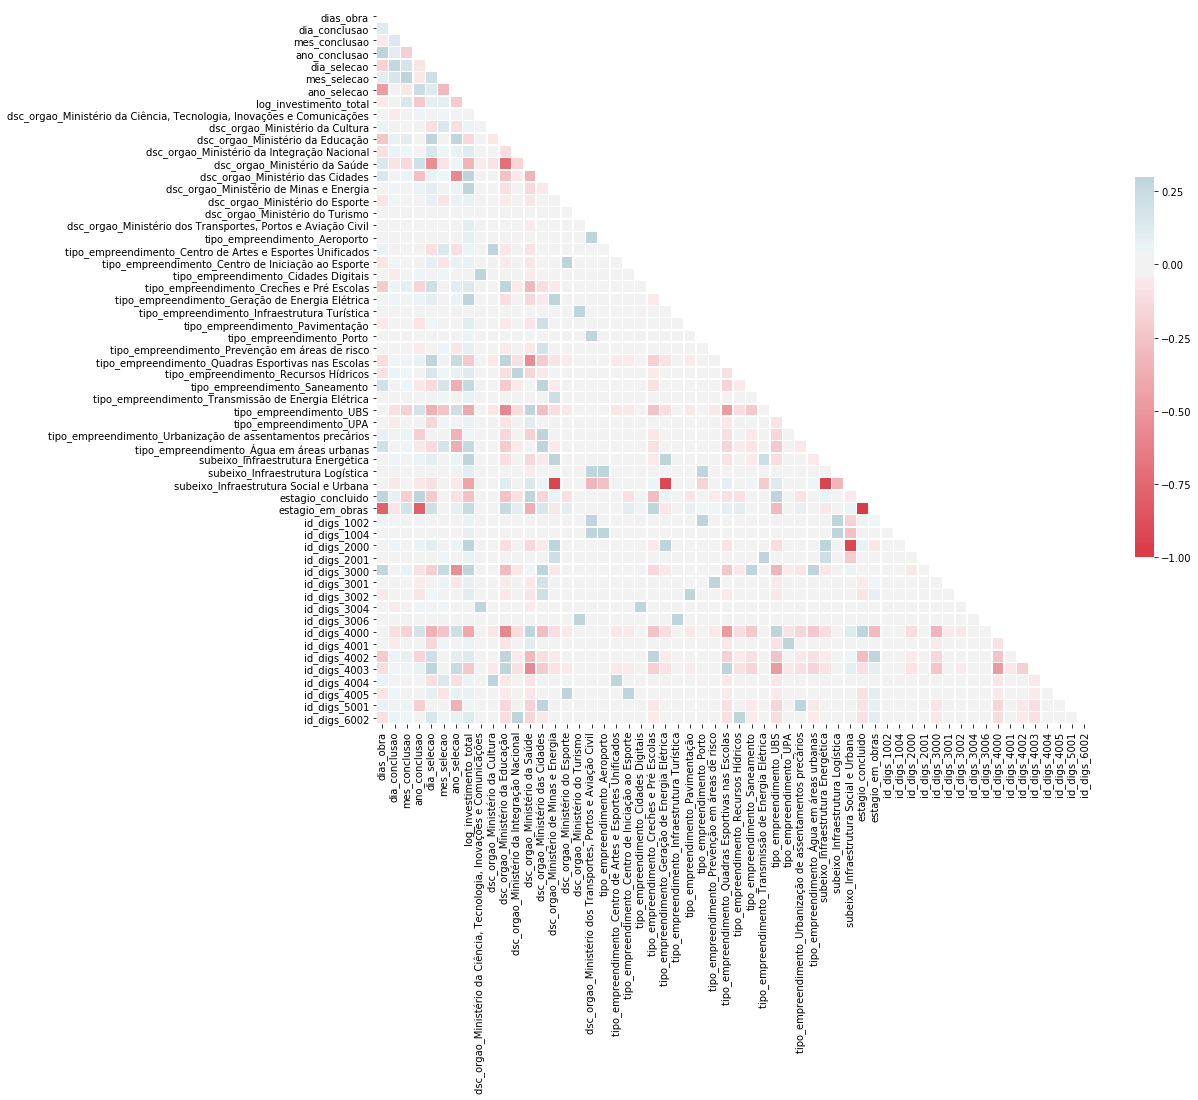

In [51]:
from matplotlib.pyplot import figure
figure(figsize=(16, 14))
corr = pacba17_dummies.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Shuffle and Split Data

In [52]:
features = pacba17_dummies.drop(columns='log_investimento_total')
prices = pacba17_dummies['log_investimento_total']

In [53]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.3, random_state=10)

print "Training and testing split was successful."

Training and testing split was successful.


/usr/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Evaluation Metrics

1. Mean Absolute Error (MAE).
2. Mean Square Error (MSE).
3. Root Mean Square Error (RMSE).

In [54]:
from sklearn.linear_model import ElasticNet, Lasso, LassoCV, Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

/usr/lib/python2.7/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [55]:
def evaluate(X, Y,model):
    scores = ['neg_mean_absolute_error','neg_mean_squared_error','r2']
    results = 0
    for score in scores:
        results = cross_val_score(model, X, Y, cv=kfold, scoring=score)
        print('{}| mean {}| std {}'.format(score,results.mean(),results.std()))

In [56]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [57]:
LN = LinearRegression()
evaluate(features, prices, LN)

neg_mean_absolute_error| mean -0.715145315041| std 0.0340732043605
neg_mean_squared_error| mean -1.0224164542| std 0.157138369136
r2| mean 0.603311309489| std 0.0632723816291


#### Benchmark Model

In [58]:
LN.fit(X_train, y_train)
y_pred = LN.predict(X_test)

In [59]:
def evaluate_model(model, y, y_pred):
    assert len(y) == len(y_pred)
    print('-'*40)
    print(model)
    print('Mean Square Error:{:.2}'.format(mean_squared_error(y, y_pred)))
    print('Mean Absolute Error:{:.2}'.format(mean_absolute_error(y, y_pred)))
    print('Root Mean Square Error:{:.2}'.format(np.sqrt(mean_squared_error(y, y_pred))))

----------------------------------------
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean Square Error:0.96
Mean Absolute Error:0.71
Root Mean Square Error:0.98


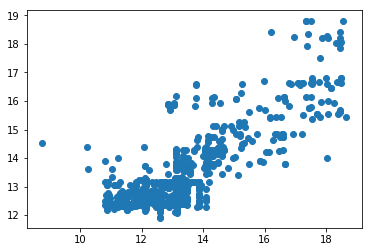

In [60]:
evaluate_model(LN,y_test, y_pred)
plt.scatter(y_test, y_pred)

## Model Selection

In [61]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [62]:
models = {"RandomForest_Regressor" : RandomForestRegressor(n_estimators = 15, min_samples_split=2, random_state = 42, min_samples_leaf=1),
"KNeighbors_Regressor" : KNeighborsRegressor(n_neighbors= 3),
"ExtraTrees_Regressor" : ExtraTreesRegressor(n_estimators=8, criterion='mse'),
"SVRegressor" : SVR(kernel='rbf', gamma='auto'),
"AdaBoost_Regressor" : AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators = 15,random_state = 42)),
"Bagging_Regressor" : BaggingRegressor(),
"GradientBoosting_Regressor" : GradientBoostingRegressor()}

In [63]:
for name, model in models.items():
    start = datetime.now()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    finish = datetime.now()
    evaluate_model(name, y_test, y_pred)
    print("Runnig time: {:.2}s".format((finish - start).total_seconds()))

----------------------------------------
RandomForest_Regressor
Mean Square Error:0.69
Mean Absolute Error:0.53
Root Mean Square Error:0.83
Runnig time: 0.16s
----------------------------------------
SVRegressor
Mean Square Error:1.3
Mean Absolute Error:0.7
Root Mean Square Error:1.1
Runnig time: 0.6s
----------------------------------------
ExtraTrees_Regressor
Mean Square Error:0.66
Mean Absolute Error:0.51
Root Mean Square Error:0.81
Runnig time: 0.064s
----------------------------------------
KNeighbors_Regressor
Mean Square Error:1.3
Mean Absolute Error:0.74
Root Mean Square Error:1.1
Runnig time: 0.029s
----------------------------------------
GradientBoosting_Regressor
Mean Square Error:0.67
Mean Absolute Error:0.57
Root Mean Square Error:0.82
Runnig time: 0.28s
----------------------------------------
Bagging_Regressor
Mean Square Error:0.69
Mean Absolute Error:0.53
Root Mean Square Error:0.83
Runnig time: 0.099s
----------------------------------------
AdaBoost_Regressor
Mean 

### Tunning Model Parameters

#### Gradient Boosting Regressor

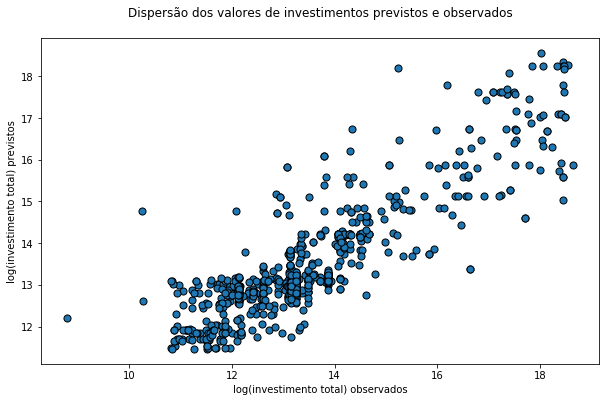

In [99]:
GBR = models['GradientBoosting_Regressor']
GBR.fit(X_train, y_train)
y_pred = GBR.predict(X_test)
plt.figure(figsize=[10,6])
plt.scatter(y_test, y_pred, edgecolors='black', s=50)
plt.title(u'Dispersão dos valores de investimentos previstos e observados\n')
plt.xlabel('log(investimento total) observados')
plt.ylabel('log(investimento total) previstos')
plt.savefig('GBR_scatter.png')

#### Random Forest Regressor

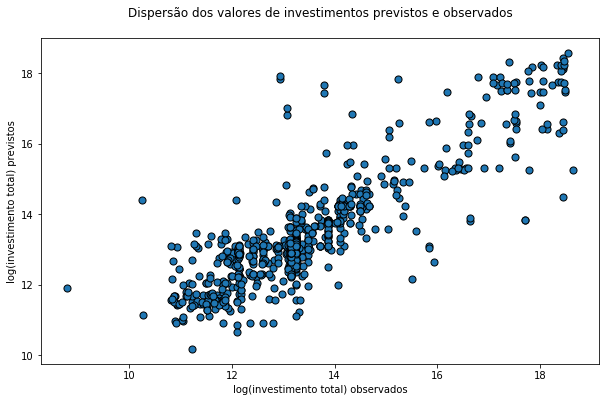

In [118]:
RF = models['RandomForest_Regressor']
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
plt.figure(figsize=[10,6])
plt.scatter(y_test, y_pred, edgecolors='black', s=50)
plt.title(u'Dispersão dos valores de investimentos previstos e observados\n')
plt.xlabel('log(investimento total) observados')
plt.ylabel('log(investimento total) previstos')
plt.savefig('GBR_scatter.png')

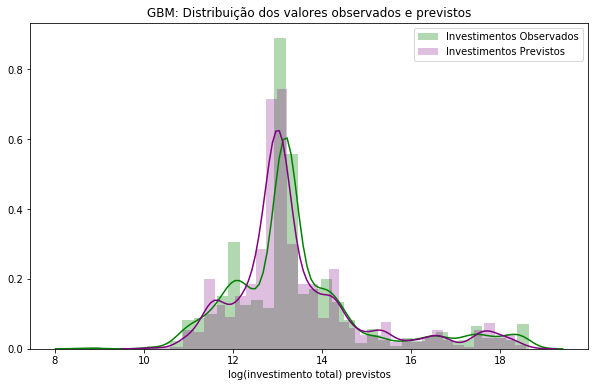

In [184]:
import seaborn as sns
from scipy.stats import norm
plt.figure(figsize=[10,6])
fig = sns.distplot(y_test, color='green', hist_kws=dict(alpha=0.3), label='Investimentos Observados').get_figure()
fig = sns.distplot(y_pred, color = 'purple', hist_kws=dict(alpha=0.25), label='Investimentos Previstos').get_figure()
plt.legend()
plt.xlabel('log(investimento total) previstos')
plt.title(u'GBM: Distribuição dos valores observados e previstos')
plt.show(fig)
fig.savefig('GBM_dist.png')

In [229]:
residuos = y_pred - y_test
avg = '%.*f' % (3, np.average(residuos))
avg = u'avg: ' + str(avg)
std = '%.*f' % (3, np.std(residuos))
std = u'std:   ' + str(std)

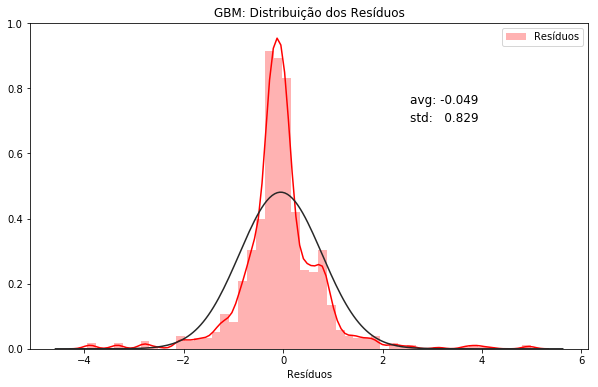

In [230]:
plt.figure(figsize=[10,6])
fig = sns.distplot(residuos, color='red', fit = norm,hist_kws=dict(alpha=0.3), label=u'Resíduos').get_figure()
plt.legend()
fig.text(0.7, 0.7, avg, size=12, ha='center', va='center')
fig.text(0.7, 0.66, std, size=12, ha='center', va='center')
plt.xlabel(u'Resíduos')
plt.title(u'GBM: Distribuição dos Resíduos')
plt.show(fig)
fig.savefig('GBM_residuos.png')

#### Tunando o Modelo